In [1]:
import pandas as pd
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
try:
    stop_words = set(stopwords.words("english"))
except LookupError:
    nltk.download("stopwords", quiet=True)
    nltk.download("wordnet", quiet=True)
    nltk.download('omw-1.4', quiet=True)
    stop_words = set(stopwords.words("english"))

In [3]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

def flatten_jsonl_data(file_path):
    all_messages = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            # satırın başındaki/sonundaki boşlukları temizle
            line = line.strip()
            
            # eğer satır boşsa (dosya sonundaki boş satır gibi), bu satırı atla
            if not line:
                continue
            
            # satırı bir JSON objesi olarak yükle
            row = json.loads(line)
            
            for i in range(len(row["messages"])):
                message_data = {
                    'game_id': row['game_id'],
                    'speaker': row['speakers'][i],
                    'receiver': row['receivers'][i],
                    'message_text': row['messages'][i],
                    'sender_intention': row['sender_labels'][i],
                    'game_score': row['game_score'][i],
                    'game_score_delta': row['game_score_delta'][i],
                    'year': row['years'][i],
                    'season': row['seasons'][i],
                    'original_fold': row.get('acl2020_fold', os.path.basename(file_path).split('.')[0])
                }
                all_messages.append(message_data)
                
    return pd.DataFrame(all_messages)

def process_dataframe(df):
    df_processed = df.copy()
    
    df_processed['target'] = df_processed['sender_intention'].apply(lambda x: 1 if x == False else 0)
    df_processed['cleaned_text'] = df_processed['message_text'].apply(clean_text)
    
    numeric_cols = ['game_score', 'game_score_delta', 'year']
    for col in numeric_cols:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    
    df_processed = df_processed.fillna(0)
    
    df_processed['message_length'] = df_processed['message_text'].apply(len)
    
    return df_processed

In [4]:
base_project_path = os.path.dirname(os.getcwd())
data_folder_path = os.path.join(base_project_path, "data", "raw", "2020_acl_diplomacy", "data")
train_path = os.path.join(data_folder_path, "train.jsonl")
val_path = os.path.join(data_folder_path, "validation.jsonl")
test_path = os.path.join(data_folder_path, "test.jsonl")

In [5]:
OUTPUT_DIR = os.path.join(base_project_path, "data", "processed", "diplomacy")
os.makedirs(OUTPUT_DIR, exist_ok=True)
OUTPUT_FILE_PATH = os.path.join(OUTPUT_DIR, "diplomacy_processed.parquet")
TRAIN_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "train_processed.parquet")
VAL_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "val_processed.parquet")
TEST_OUTPUT_PATH = os.path.join(OUTPUT_DIR, "test_processed.parquet")

In [7]:
if os.path.exists(OUTPUT_FILE_PATH):
    # eğer dosya varsa, ağır işi atla ve dosyayı doğrudan yükle
    df_eda = pd.read_parquet(OUTPUT_FILE_PATH)
    
else:
    # eğer dosya yoksa
    df_train = flatten_jsonl_data(train_path)
    df_val = flatten_jsonl_data(val_path)
    df_test = flatten_jsonl_data(test_path)

    df_eda = pd.concat([df_train, df_val, df_test], ignore_index=True)
    print(f"Total length: {len(df_eda)}")
    
    df_train = process_dataframe(df_train)
    df_val = process_dataframe(df_val)
    df_test = process_dataframe(df_test)
    df_eda = process_dataframe(df_eda)

    df_train.to_parquet(TRAIN_OUTPUT_PATH, index=False)
    df_val.to_parquet(VAL_OUTPUT_PATH, index=False)
    df_test.to_parquet(TEST_OUTPUT_PATH, index=False)

    df_eda.to_parquet(OUTPUT_FILE_PATH, index=False)

print("\nCompleted. Info: ")
print(df_eda.info())
print(df_train.info())
print(df_val.info())
print(df_test.info())

Total length: 17289

Completed. Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17289 entries, 0 to 17288
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   game_id           17289 non-null  int64 
 1   speaker           17289 non-null  object
 2   receiver          17289 non-null  object
 3   message_text      17289 non-null  object
 4   sender_intention  17289 non-null  bool  
 5   game_score        17289 non-null  int64 
 6   game_score_delta  17289 non-null  int64 
 7   year              17289 non-null  int64 
 8   season            17289 non-null  object
 9   original_fold     17289 non-null  object
 10  target            17289 non-null  int64 
 11  cleaned_text      17289 non-null  object
 12  message_length    17289 non-null  int64 
dtypes: bool(1), int64(6), object(6)
memory usage: 1.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13132 entries, 0 to 13131
Data columns (total 13

In [12]:
base_path = os.path.dirname(os.getcwd())
data_path = os.path.join(base_path, "data", "processed", "diplomacy", "diplomacy_processed.parquet")
reports_dir = os.path.join(base_path, "reports", "figures")
os.makedirs(reports_dir, exist_ok=True)

In [13]:
try:
    data = pd.read_parquet(data_path)
    sns.set_theme(style="whitegrid")
except FileNotFoundError:
    print(f"ERROR: '{data_path}' FILE NOT FOUND!")

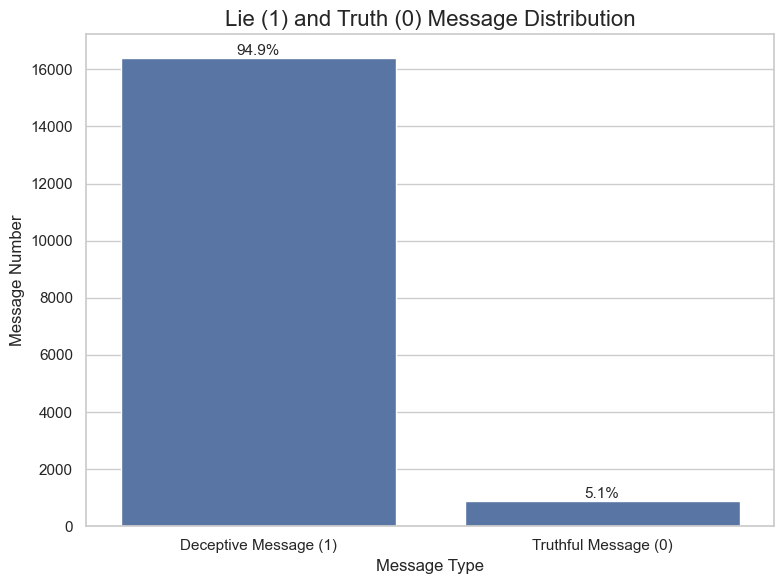

In [14]:
plt.figure(figsize=(8, 6))
ax1 = sns.countplot(x='target', data=data) 
plt.title('Lie (1) and Truth (0) Message Distribution', fontsize=16)
plt.xlabel('Message Type', fontsize=12)
plt.ylabel('Message Number', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Deceptive Message (1)', 'Truthful Message (0)'])

total = len(data)
for p in ax1.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 100
    ax1.annotate(percentage, (x, y), ha='center', fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(reports_dir, "diplomacy_01_class_distribution.png"))
plt.show()

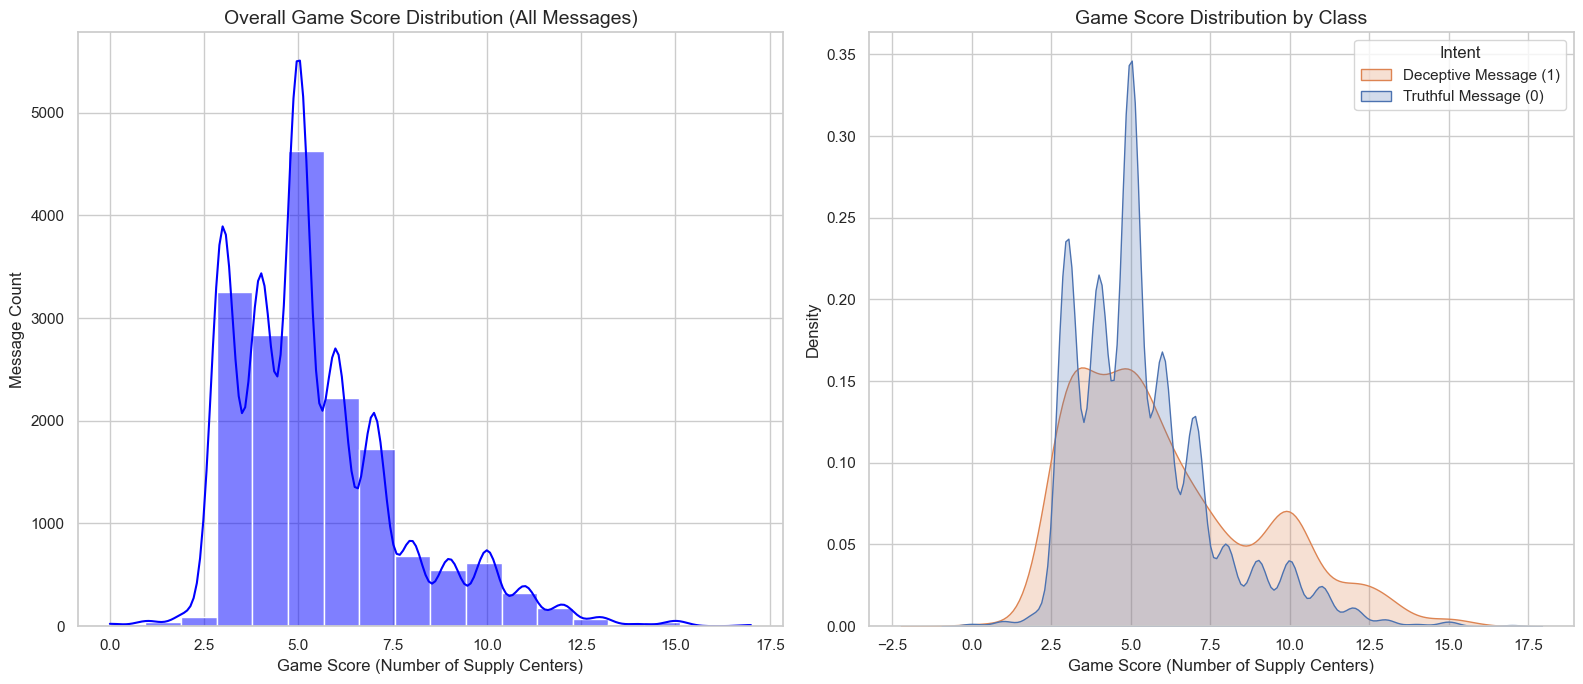

In [15]:
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)  
sns.histplot(data=data, x='game_score', bins=18, kde=True, color='blue')
plt.title('Overall Game Score Distribution (All Messages)', fontsize=14)
plt.xlabel('Game Score (Number of Supply Centers)', fontsize=12)
plt.ylabel('Message Count', fontsize=12)

plt.subplot(1, 2, 2)
sns.kdeplot(data=data, x='game_score', hue='target', 
            fill=True, common_norm=False) 
plt.title('Game Score Distribution by Class', fontsize=14)
plt.xlabel('Game Score (Number of Supply Centers)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Intent', labels=['Deceptive Message (1)', 'Truthful Message (0)'])

plt.tight_layout()
plt.savefig(os.path.join(reports_dir, "diplomacy_02_score_distribution.png"))
plt.show()

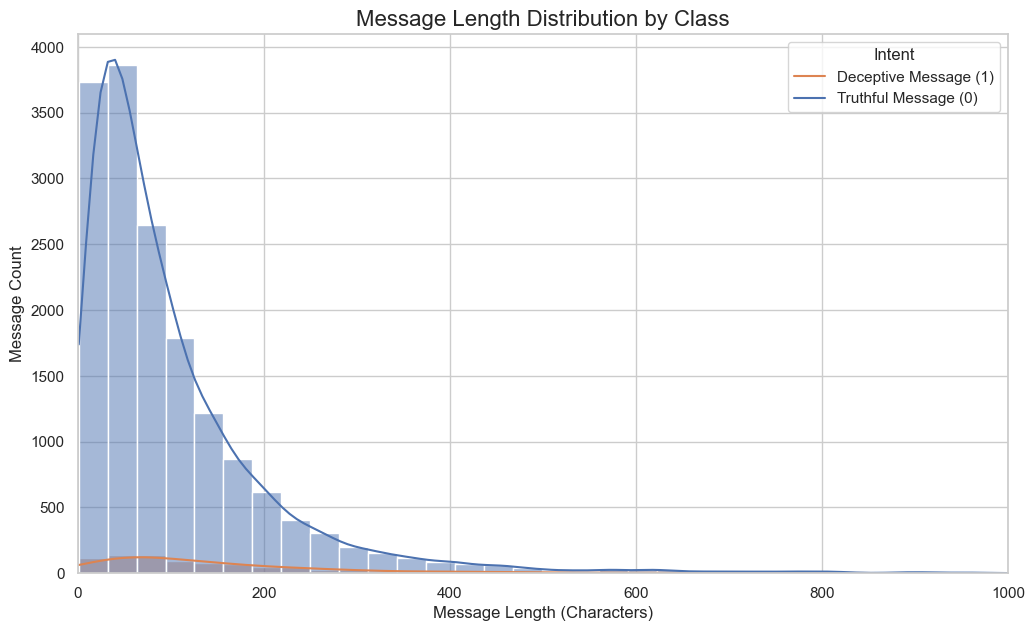

In [16]:
plt.figure(figsize=(12, 7))
sns.histplot(data=data, x='message_length', hue='target', 
  bins=50, kde=True, common_norm=False)
plt.title('Message Length Distribution by Class', fontsize=16) 
plt.xlabel('Message Length (Characters)', fontsize=12) 
plt.ylabel('Message Count', fontsize=12) 

plt.xlim(0, 1000) 
plt.legend(title='Intent', labels=['Deceptive Message (1)', 'Truthful Message (0)']) 
plt.savefig(os.path.join(reports_dir, "diplomacy_03_length_distribution.png"))
plt.show()

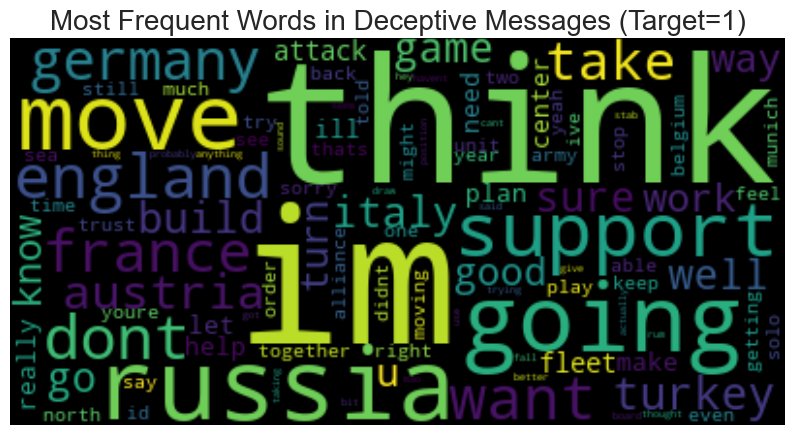

In [17]:
spam_text = " ".join(review for review in data[data['target'] == 1]['cleaned_text'] if review)

if spam_text:
    plt.figure(figsize=(10, 7))
    wordcloud_spam = WordCloud(max_words=100, background_color="black", collocations=False).generate(spam_text)
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.axis("off")
    plt.title("Most Frequent Words in Deceptive Messages (Target=1)", fontsize=20)
    plt.savefig(os.path.join(reports_dir, "diplomacy_04_wordcloud_lie.png"))
    plt.show()
else:
    print("No text found to generate word cloud for deceptive messages.")

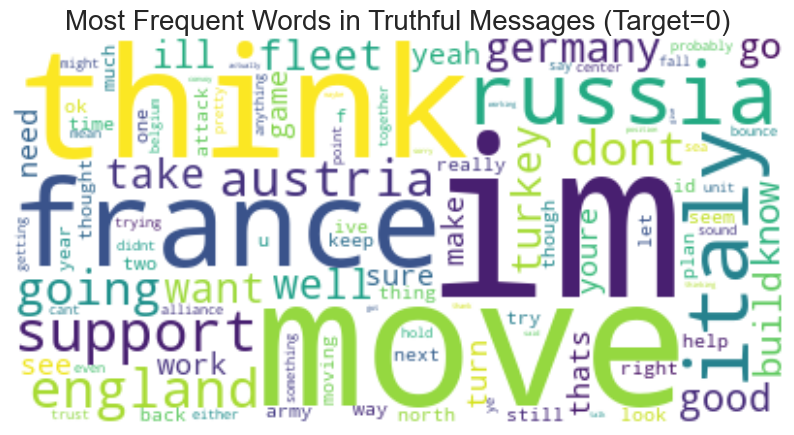

In [18]:
real_text = " ".join(review for review in data[data['target'] == 0]['cleaned_text'] if review)

if real_text:
    plt.figure(figsize=(10, 7))
    wordcloud_real = WordCloud(max_words=100, background_color="white", collocations=False).generate(real_text)
    plt.imshow(wordcloud_real, interpolation='bilinear')
    plt.axis("off")
    plt.title("Most Frequent Words in Truthful Messages (Target=0)", fontsize=20)
    plt.savefig(os.path.join(reports_dir, "diplomacy_04_wordcloud_truth.png"))
    plt.show()
else:
    print("No text found to generate word cloud for truthful messages.")